# 3D spectral analysis of HESS J1745-290 (with HAP-fr)

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [186]:
from pathlib import Path

# Directory for outputs

path = Path("../../../../gammapy_data/GC_variability2020/hap-fr")
path.mkdir(exist_ok=True)

pathm = Path("../../../../gammapy_data/GC_variability2020/hap-fr/models")
pathm.mkdir(exist_ok=True)

## Creating the geometry

In [187]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, e_bins, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy", interp="log"
)

In [188]:
# Creating the total dataset

mapdataset_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdatasets/mapdataset_tot.fits.gz"
mapdataset_tot = MapDataset.read(path/filename)

## Reading the model template

In [ ]:
pathmo = Path("../../../../gammapy_data/GC_variability2020_full/hap-fr/models")
pathmo.mkdir(exist_ok=True)

name = pathmo/"models_template.yaml"
modelGC,modelG09, modeldiff = SkyModels.read(name)

#name = pathmo/"models_template_1cutoff.yaml"
#modelGC,modelG09, modeldiff = SkyModels.read(name)

#name = pathmo/"models_template_2cutoff.yaml"
#modelGC,modelG09, modeldiff = SkyModels.read(name)

## Constructing the mask

In [213]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

#éventuellement étendre le masque

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Function used to fit a given dataset

In [214]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    return table, result

# Fitting the total dataset

Stacking all three datasets tends to give poor results, trying to fit HESS1+2 on the one hand, and HESS1U on the other might be more succesful.

In [215]:
mapdataset_tot.fit_mask = fit_mask
mapdataset_tot.models =  model.copy() + modelG09.copy()+ model_diff.copy()
mapdataset_tot.background_model.parameters['norm'].value = 1.0

In [216]:
%%time

table,  result = fit_dataset(mapdataset_tot)

CPU times: user 3min 21s, sys: 17 s, total: 3min 38s
Wall time: 3min 38s


In [217]:
### Adding (covariance computed) errors to the model objects

mapdataset_tot.models[0].spectral_model.parameters.covariance = (
    result.parameters.covariance[2:7,2:7]
)

mapdataset_tot.models[2].spectral_model.parameters.covariance = (
    result.parameters.covariance[2:7,2:7]
)

In [224]:
%%time

# estimating the error on the diffuse emission cutoff (or lambda_)
param = mapdataset_tot.models[2].spectral_model.parameters["lambda_"]

fit = Fit([mapdataset_tot])

fit.optimize()
confresult = fit.confidence(parameter = param, sigma=1)

CPU times: user 4min 12s, sys: 21.3 s, total: 4min 33s
Wall time: 4min 33s


In [235]:
# not ideal, lambda_ for the DE is the 17th variable (index 16)

print(confresult['errp'], confresult['errp'], table['error'][16])

0.01700654637372629 0.01700654637372629 0.013286087658075513


In [233]:
table

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,1.967e+00,5.219e-02,,nan,nan,False
amplitude,2.041e-12,6.260e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lambda_,1.304e-01,1.954e-02,TeV-1,nan,nan,False
alpha,1.000e+00,0.000e+00,,nan,nan,True
lon_0,8.791e-01,0.000e+00,deg,nan,nan,True
lat_0,8.930e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True


In [236]:
def fit_dataset_contour(mapdataset, param1, param2):
    fit = Fit([mapdataset])

    fit.optimize()
    res = fit.minos_contour(param1, param2, numpoints=10, sigma=1.0) # attention aux indices !!
   
    return res

In [237]:
%%time

param1 = mapdataset_tot.models[2].spectral_model.parameters["lambda_"]
param2 = mapdataset_tot.models[2].spectral_model.parameters["index"]

rescontour = fit_dataset_contour(mapdataset_tot, param1, param2)

In [238]:
rescontour

{'x': array([0.09690064, 0.10399571, 0.11175858, 0.11967736, 0.12778241,
        0.12953876, 0.12235334, 0.11457038, 0.10665416, 0.09855265]),
 'y': array([1.85675737, 1.81525474, 1.78823138, 1.76717452, 1.75513574,
        1.76074214, 1.80081979, 1.82749961, 1.84913096, 1.86221305]),
 'success': True,
 'x_info': -------------------------------------------------
| par_006_lambda_ |            Valid            |
-------------------------------------------------
|      Error      |    -0.16     |     0.17     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------,
 'y_info': -------------------------------------------------
|  par_004_index  |            Valid            |
-------------------------------------------------
|      Error      |    -0.05     |     0.05     |
|      Valid      |    

# Contours for the diffuse emission cutoff

taken from https://docs.gammapy.org/0.17/notebooks/modeling.html

In [ ]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["alpha", "beta", "amplitude"], r=2): # à modifier
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour["x"].tolist(),
                par_2: contour["y"].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [ ]:
%%time
sigma = [1, 2] # estimating the contour for 1 and 2 sigmas

cts_sigma = make_contours(fit, result_minuit, 10, sigma) # beware of the parameter selection

In [ ]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
}

panels = [
    {
        "x": "alpha",
        "y": "phi",
        "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_alpha_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "beta",
        "y": "phi",
        "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_beta_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "alpha",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigma[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

# Results

## Spectrum

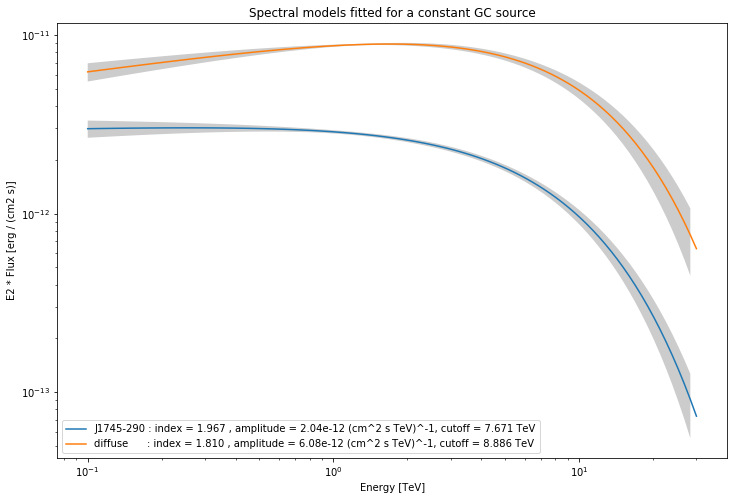

In [245]:
plt.figure(figsize=(12,8))
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

index = mapdataset_tot.models[0].spectral_model.parameters["index"].value
amp = mapdataset_tot.models[0].spectral_model.parameters["amplitude"].value
cutoff = 1/mapdataset_tot.models[0].spectral_model.parameters["lambda_"].value

# plot stacked model
mapdataset_tot.models[0].spectral_model.plot(
    **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff)
)
mapdataset_tot.models[0].spectral_model.plot_error(**plot_kwargs)

index = mapdataset_tot.models[2].spectral_model.parameters["index"].value
amp = mapdataset_tot.models[2].spectral_model.parameters["amplitude"].value
cutoff = 1/mapdataset_tot.models[2].spectral_model.parameters["lambda_"].value

mapdataset_tot.models[2].spectral_model.plot(
    **plot_kwargs, label=r"diffuse      : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff)
)
mapdataset_tot.models[2].spectral_model.plot_error(**plot_kwargs)

plt.title("Spectral models fitted for a constant GC source")
plt.legend()
#plt.savefig(path/"constant_model_2fit_fr.pdf")

In [89]:
# flux points can be computed if the high level interface is used

## Model predictions

(<Figure size 432x432 with 1 Axes>,
 None)

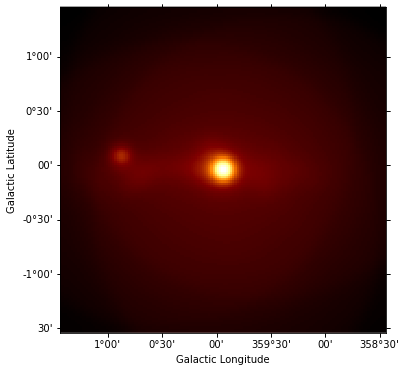

In [173]:
pathma = Path(path/"models/maps")
pathma.mkdir(exist_ok=True)

plt.figure(figsize=(6,6))
mapdataset_tot.npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.savefig(pathma/"model_tot_map.pdf")

## Residuals

Text(0.5, 1.0, '')

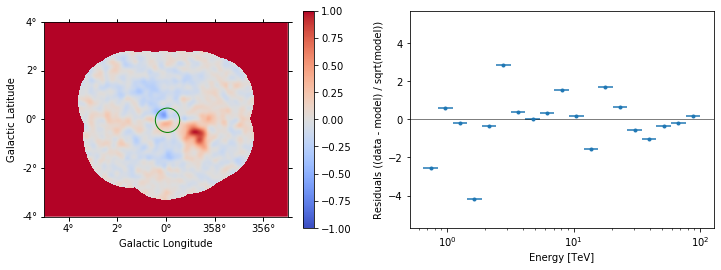

In [174]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

pathr = Path(path/"residuals")
pathr.mkdir(exist_ok=True)

mapdataset_tot.plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
name = "residuals_tot.pdf"
plt.title("")
#plt.savefig(pathr/name, overwrite=True)

## Significance map

Text(0.5, 1.0, 'Significance map (data v. model predictions)')

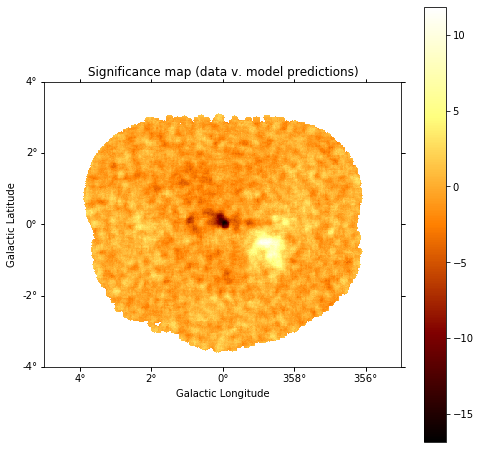

In [92]:
paths = Path(path/"significance")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5)

plt.figure(figsize=(8,8))
counts = mapdataset_tot.counts.sum_over_axes()
mod = mapdataset_tot.npred().sum_over_axes()
lima_significance = compute_lima_image(counts, mod, kernel)
    
lima_significance['significance'].plot(add_cbar=True)
name = "significance_map_tot.pdf"
plt.title("Significance map (data v. model predictions)")
#plt.savefig(paths/name, overwrite=True)

## Significance distribution

Text(0.5, 1.0, 'Significance distribution for the central (3°,2°)')

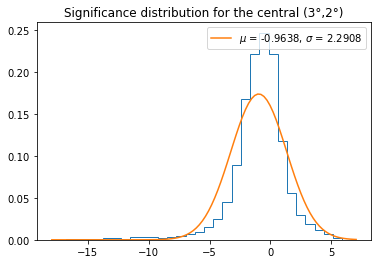

In [93]:
pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

plt.figure()
signidata = lima_significance['significance'].cutout(position=src_pos, width=(3 * u.deg, 2* u.deg)).data
    
# on masque la région en bas à droite
mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data

plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
mean,std=norm.fit(signidata[mask])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    
plt.legend(loc=1)
    
name = "significance_distribution_tot.pdf"
plt.title("Significance distribution for the central (3°,2°)")
#plt.savefig(pathh/name, overwrite=True)